# Visualize fluorescence preprocessing pipeline for whole recordings

This notebook is a step-by-step visualization of the preprocessing pipeline with output plots and explanations. The scripts `preprocess_data_SC.py` and `preprocess_data_DC.py` automate this workflow for all experiments.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter, percentile_filter

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import paths
import functions_preprocessing as fpp
import functions_io as f_io
import functions_plotting as fp
from functions_utils import find_zone_and_behavior_episodes, add_episode_data

f_io.check_dir_exists(paths.figure_directory)

## Define some plotting functions
Run these cells before beginning youy exploration

In [2]:
def plot_two_traces(time, trace1, trace2, **kwargs):    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(9,6), **kwargs)
    
    axes[0] = fp.plot_fluorescence_min_sec(time, trace1, ax=axes[0])
    axes[0].set_ylabel('Fluorescence (AU)')
    
    axes[1] = fp.plot_fluorescence_min_sec(time, trace2, ax=axes[1])
    axes[1].set_ylabel('Fluorescence (AU)')
    axes[1].set_xlabel('Time')
    
    return fig, axes

In [3]:
def plot_sc_experiment(file):
    
    data = f_io.read_1_channel_fiber_photometry_csv(file.resolve())
    
    fig, axes = plot_two_traces(data['time'], data['gcamp'], data['auto'])
    
    axes[0].set_title('Raw GCaMP')
    axes[1].set_title('Raw Auto')
    
    plt.tight_layout()
    return data

## Load a list of raw data files
This searches for all the csv's of raw data in your directory, so you can pick them from the dropdon in the next cell

In [4]:
files = Path(paths.csv_directory).glob('*.csv')
file_shorthand = [('Day {} Animal {}'.format(p.stem.split('_')[0][-1], p.stem.split('_')[-1][0:]), p) for p in files]
file_shorthand = sorted(file_shorthand, key=lambda fs: fs[0])

## Visualize raw traces

Here we notice some disconinuities and jumps in the data set. We need to figure out what to do with them to clean this up.

In [5]:
y = interactive(plot_sc_experiment, file=widgets.Dropdown(options=file_shorthand, description='Experiment:'))
display(y)

interactive(children=(Dropdown(description='Experiment:', options=(('Day 1 Animal 1', PosixPath('data/Multimaz…

## Remove NaNs

These traces have some NaNs in them. This affects later processing. The function `fpp.remove_nans` finds these values and removes them by interpolating.

In [6]:
data_df = y.result
gcamp = data_df.gcamp.to_numpy()
gcamp = fpp.remove_nans(gcamp)

auto = data_df.auto.to_numpy()
auto = fpp.remove_nans(auto)

<IPython.core.display.Javascript object>


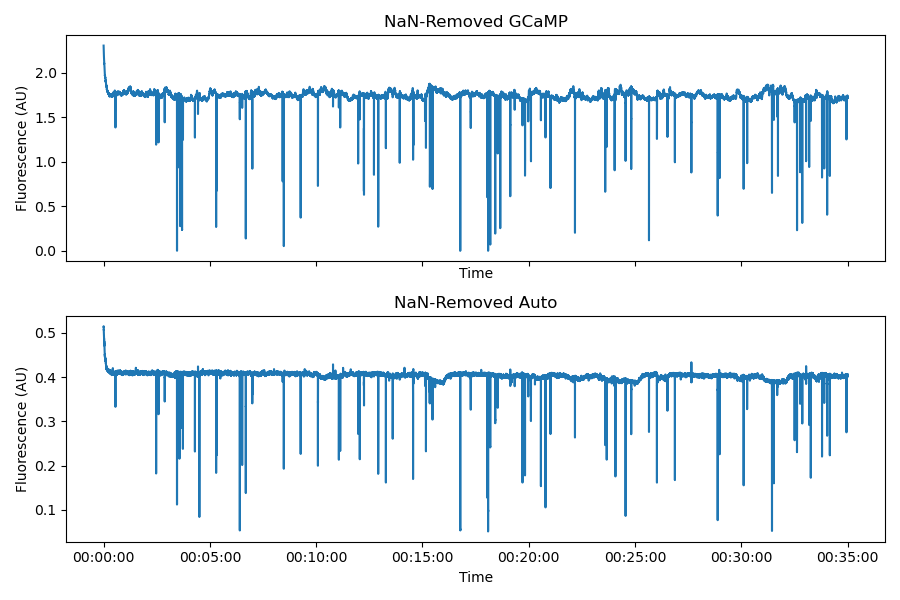

In [7]:
fig, axes = plot_two_traces(data_df.time, gcamp, auto)
axes[0].set_title('NaN-Removed GCaMP')
axes[1].set_title('NaN-Removed Auto')
plt.tight_layout()

## Run a percentile filter to remove major artifacts

<IPython.core.display.Javascript object>


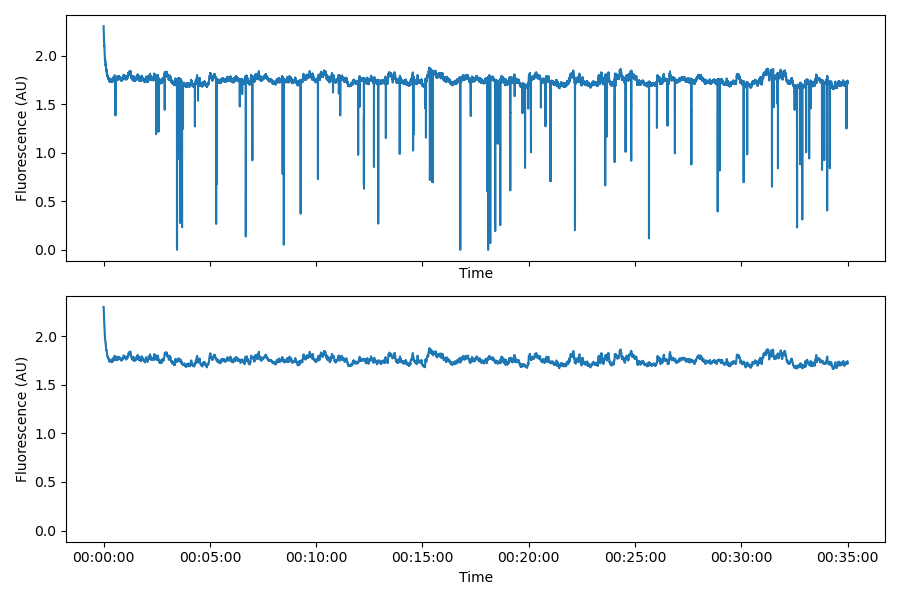

In [33]:
gcamp_percentile = percentile_filter(gcamp, percentile=99, size=25)
fig, axes = plot_two_traces(data_df.time, gcamp, gcamp_percentile, sharey=True)
plt.tight_layout()

In [27]:
def windowed_median(trace, window_size, std_multiplier=2):
    new_trace = trace.copy()
    
    windows = np.arange(0, len(trace), window_size)
    
    if windows[-1] < len(trace):
        np.append(windows, len(trace))
    
    
    for i, (start, stop) in enumerate(zip(windows[:-1], windows[1:])):
        sample = trace[start:stop].copy()
        sample_med = np.nanmedian(sample)
        sample_std = np.nanstd(sample)
        
        mask = np.argwhere((sample > (sample_med + std_multiplier*sample_std)) | (sample < (sample_med - std_multiplier*sample_std)))
        sample[mask] = sample_med
        
        new_trace[start:stop] = sample
        
    return new_trace

<IPython.core.display.Javascript object>


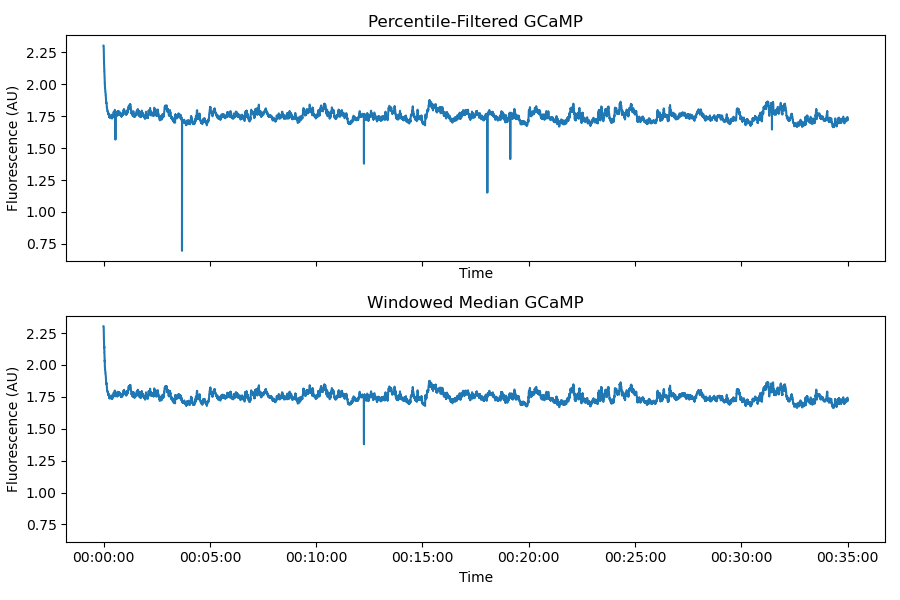

In [32]:
filtered2 = windowed_median(gcamp_percentile, window_size=10)
fig, axes = plot_two_traces(data_df.time, gcamp_percentile, filtered2, sharey=True)
axes[0].set_title('Percentile-Filtered GCaMP')
axes[1].set_title('Windowed Median GCaMP')
plt.tight_layout()

In [39]:
print(np.median(asec), np.std(asec))
med = np.median(asec)
astd = np.std(asec)

mask = np.argwhere((asec > med + 2*astd) | (asec < med - 2*astd)) 
asec[mask] = 

fig, axes = plot_two_traces(ts, gs, asec)
plt.tight_layout()

0.38198319425000005 0.0013071834270882482


ValueError: object too deep for desired array

# Find periods where the signal is lost

Notice that sometimes the signal is lost, and a flat line is found in the data. We identify these sections by calculating the derivative of both channels. Where the derivative is zero, the signal is flat and presumably lost. Find where this occurs in both signals, and replace with np.NaN

In [ ]:
d_gcamp = np.r_[0, np.abs(np.diff(gcamp))]
d_auto = np.r_[0, np.abs(np.diff(auto))]
gcamp_d0 = np.where(d_gcamp == 0)[0]
auto_d0 = np.where(d_auto == 0)[0]
shared_zero = np.unique(np.concatenate((gcamp_d0, auto_d0)))

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True)
# axes[0][0].plot(data_df.time, gcamp)
# axes[1][0].plot(data_df.time, d_gcamp)
# axes[0][1].plot(data_df.time, auto, c='orange')
# axes[1][1].plot(data_df.time, d_auto, c='orange')

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
# axes[0].plot(data_df.time, gcamp)
# axes[1].plot(data_df.time, auto, c='orange')

# High pass filter to remove the decay

Notice that there is a decay throughout the experiment. High pass filter (>0.1 Hz) to remove this.

In [53]:
import scipy.signal as sig
fs = 40 


def butter_highpass(cutoff, order, fs):
    nyq = 0.5 * fs
    high_cut = cutoff / nyq
    b, a = sig.butter(order, high_cut, btype='highpass')
    return b, a

In [56]:
def plot_hpf(signal, cutoff, order, fs):
    
    b, a = butter_highpass(cutoff, order, fs)
    signal_hpf = sig.filtfilt(b, a, signal)
    
    fig, axes = plot_two_traces(data_df.time, signal, signal_hpf, sharey=True)
    axes[0].set_title('Original Signal')
    axes[1].set_title('High-Pass Filtered Signal')
    plt.tight_layout()
    
    return signal_hpf

In [57]:
y=interactive(plot_hpf,
              signal=fixed(gcamp_percentile), 
              cutoff=(0.01, 1.0, 0.05),
              order=(1, 10, 1), 
              fs=fixed(fs))
display(y)
gcamp_hpf = y.result

interactive(children=(FloatSlider(value=0.46, description='cutoff', max=1.0, min=0.01, step=0.05), IntSlider(v…

In [ ]:
y=interactive(plot_hpf,
              signal=fixed(auto), 
              cutoff=(0.01, 1.0, 0.05),
              order=(1, 10, 1), 
              fs=fixed(fs))
display(y)
auto_hpf = y.result

# Low pass filter to remove noise artifacts

Notice that there is some jitter still in the plot. Low pass filter the data with a frequency that makes sense for the Ca2+ indicator. If GCaMP6s, this is ~10 Hz.

In [ ]:
def butter_lowpass(cutoff, order, fs):
    nyq = 0.5 * fs
    low_cut = cutoff / nyq
    b, a = sig.butter(order, low_cut, btype='lowpass')
    return b, a

In [ ]:
def plot_lpf(signal, cutoff, order, fs):
    
    b, a = butter_lowpass(cutoff, order, fs)
    signal_lpf = sig.filtfilt(b, a, signal)
    
    fig, axes = plot_two_traces(data_df.time, signal, signal_lpf, sharey=True)
    axes[0].set_title('High-Pass Filtered  Signal')
    axes[1].set_title('Low-Pass Filtered Signal')
    plt.tight_layout()
    
    return signal_lpf

In [ ]:
y=interactive(plot_lpf,
              signal=fixed(gcamp_hpf), 
              cutoff=(10, (fs/2)-1, 0.5),
              order=(1, 10, 1), 
              fs=fixed(fs))
display(y)
gcamp_lpf = y.result

In [ ]:
y=interactive(plot_lpf,
              signal=fixed(auto_hpf), 
              cutoff=(10, (fs/2)-1, 0.5),
              order=(1, 10, 1), 
              fs=fixed(fs))
auto_lpf = y.result

# Apply SavGol filter for smoothing

In [ ]:
def plot_savgol(signal, kernel=5, poly_order=2):
    if poly_order > kernel:
        poly_order = kernel-1
        
    signal_savgol = savgol_filter(signal, kernel, poly_order)

    fig, axes = plot_two_traces(data_df.time, signal, signal_savgol, sharey=True)
    axes[0].set_title('Filtered  Signal')
    axes[1].set_title('Smoothed Signal')
    plt.tight_layout()
    
    return signal_savgol

In [ ]:
y=interactive(plot_savgol,
              signal=fixed(gcamp_lpf), 
              kernel=(3, 39, 2),
              poly_order=(1, 5, 1))

display(y)
gcamp_smooth = y.result

In [ ]:
y=interactive(plot_savgol,
              signal=fixed(auto_lpf), 
              kernel=(3, 39, 2),
              poly_order=(1, 5, 1))

display(y)
auto_smooth = y.result

# Remove periods where signal is lost

This has to be applied after filtering, because the filters can't handle NaNs

In [ ]:
gcamp_smooth[shared_zero] = np.NaN
auto_smooth[shared_zero] = np.NaN

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(data_df.time, gcamp_lps)
axes[1].plot(data_df.time, auto_lps, c='orange')